---
* ### Import as libs  
---

In [118]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from carima import generate_matrices, get_G, get_F

---
* ### Função para plotar em grade
---

In [119]:
def plot(time, y_matriz, title, cols_name, time_aux=None, y_matriz_aux=None):
    n_row, n_col = len(y_matriz), len(y_matriz[0])
    
    fig, axs = plt.subplots(n_row, n_col, figsize=(11, 7), sharex=True)

    # nome das colunas 
    for j in range(n_col):
        axs[0, j].set_title(f'{title} - {cols_name[j]}')

    for i in range(n_row):
        for j in range(n_col):
            offset_x = 0
            if y_matriz_aux is not None and time_aux is not None:
                # plota as linhas auxiliares
                dic_aux = y_matriz_aux[i][j]
                offset_x = len(dic_aux[0])
                axs[i, j].plot(time_aux[:offset_x], dic_aux[0], label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3])

                # tranforma em dt
                dt = time[1] - time[0]
                offset_x = offset_x * dt

            # plota as linhas
            dic = y_matriz[i][j]
            axs[i, j].plot(time + offset_x, dic[0], label=dic[1], color=dic[2], marker=dic[3])

            # configurações do gráfico
            axs[i, j].grid()
            axs[i, j].legend()
            #axs[i, j].set_ylim(-6, 6)
            #axs[i, j].set_ylabel(f'Output {i+1}')
    
    plt.tight_layout()
    plt.show()

def print_tf(sys):
    # printa só as ultimas 3 linhas 
    text = sys.__str__().splitlines()
    for line in text[-3:]:
        print(line)

# Converter cada canal SymPy -> control.TransferFunction SISO (em s)
def sympy_to_tf(expr_s, s_symbol):
    """Converte uma função racional em s (SymPy) -> control.TransferFunction SISO."""
    num, den = sp.fraction(sp.together(sp.simplify(expr_s)))
    num_poly = sp.Poly(num, s_symbol)
    den_poly = sp.Poly(den, s_symbol)

    # Coeficientes do maior para o menor grau
    num_cf = [float(c) for c in num_poly.all_coeffs()]
    den_cf = [float(c) for c in den_poly.all_coeffs()]
    return ctl.tf(num_cf, den_cf)

---
* ### Constantes
---

In [120]:
# massas
m0 = 5
m1 = 1

# constantes de amortecimento
c0 = 1
c1 = 0.15

# constantes de rigidez
k0 = 1.0
k1 = 1.0

# modal participation factor
beta_0 = 0.33

---
* ### Matrizes
---

In [121]:
# Matriz de massa
M = sp.Matrix([[m0, 0],
               [0, m1]])

# Matriz de amortecimento
N = sp.Matrix([[c0 + c1, -c1],
                [-c1, c1]])

# Matriz de rigidez
K = sp.Matrix([[k0 + k1, -k1],
                [-k1, k1]])

# Matriz da entrada u
B = sp.Matrix([[-1],[1]])

# Matriz da entrada do deslocamento do solo
C = sp.Matrix([[beta_0*m0],[m1]])

---
* ### Funções de transferência
---

In [122]:
t, s = sp.symbols('t s', positive=True, real=True)

# M*x'' + N*x' + K*x = B*u + C*q
# (M*s**2 + N*s + K)*X = B*U + C*Q
# AX = BU + CQ
A = M*s**2 + N*s + K

# Função de transferência do sistema
H_U = (A.inv() * B)
H_Q = (A.inv() * C)

# Simplificação das expressões
H_U = sp.simplify(H_U)
H_Q = sp.simplify(H_Q)

# matriz de transferência do sistema 
H = sp.Matrix.hstack(H_U, H_Q)

---
* ### Matriz de TF - sistema continuo
---

In [123]:
H_s_matriz = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_s_matriz[i].append(sympy_to_tf(H[i,j], s))

for hi in H_s_matriz:
    for hj in hi:
        print_tf(hj)
        print()

                   -s^2
  ---------------------------------------
  5 s^4 + 1.9 s^3 + 7.15 s^2 + 1.15 s + 1

        1.65 s^2 + 0.3975 s + 2.65
  ---------------------------------------
  5 s^4 + 1.9 s^3 + 7.15 s^2 + 1.15 s + 1

               5 s^2 + s + 1
  ---------------------------------------
  5 s^4 + 1.9 s^3 + 7.15 s^2 + 1.15 s + 1

          5 s^2 + 1.397 s + 3.65
  ---------------------------------------
  5 s^4 + 1.9 s^3 + 7.15 s^2 + 1.15 s + 1



---
* ### Matriz de TF - sistema discreto
---

In [124]:
# tempo de amostragem 
T = 0.5

H_z_matriz = [[] for _ in range(H.rows)]

# converter cada canal para TF discreto
for i in range(H.rows):
    for j in range(H.cols):
        H_z_matriz[i].append(ctl.sample_system(H_s_matriz[i][j], T, method="zoh"))

# print
for hi in H_z_matriz:
    for hj in hi:
        print_tf(hj)
        print()

  -0.02279 z^3 + 0.02419 z^2 + 0.02001 z - 0.0214
  -----------------------------------------------
   z^4 - 3.496 z^3 + 4.855 z^2 - 3.175 z + 0.827

  0.04048 z^3 - 0.02199 z^2 - 0.02428 z + 0.03507
  -----------------------------------------------
   z^4 - 3.496 z^3 + 4.855 z^2 - 3.175 z + 0.827

   0.1184 z^3 - 0.1051 z^2 - 0.1062 z + 0.1039
  ---------------------------------------------
  z^4 - 3.496 z^3 + 4.855 z^2 - 3.175 z + 0.827

  0.1212 z^3 - 0.08713 z^2 - 0.09743 z + 0.1037
  ---------------------------------------------
  z^4 - 3.496 z^3 + 4.855 z^2 - 3.175 z + 0.827



---
* ### Plot - resposta ao impulso
---

In [125]:
# dados pra simular
start = 0
stop = 150
step = T
time = np.arange(start, stop, step)

cols_name = ['u', 'q']

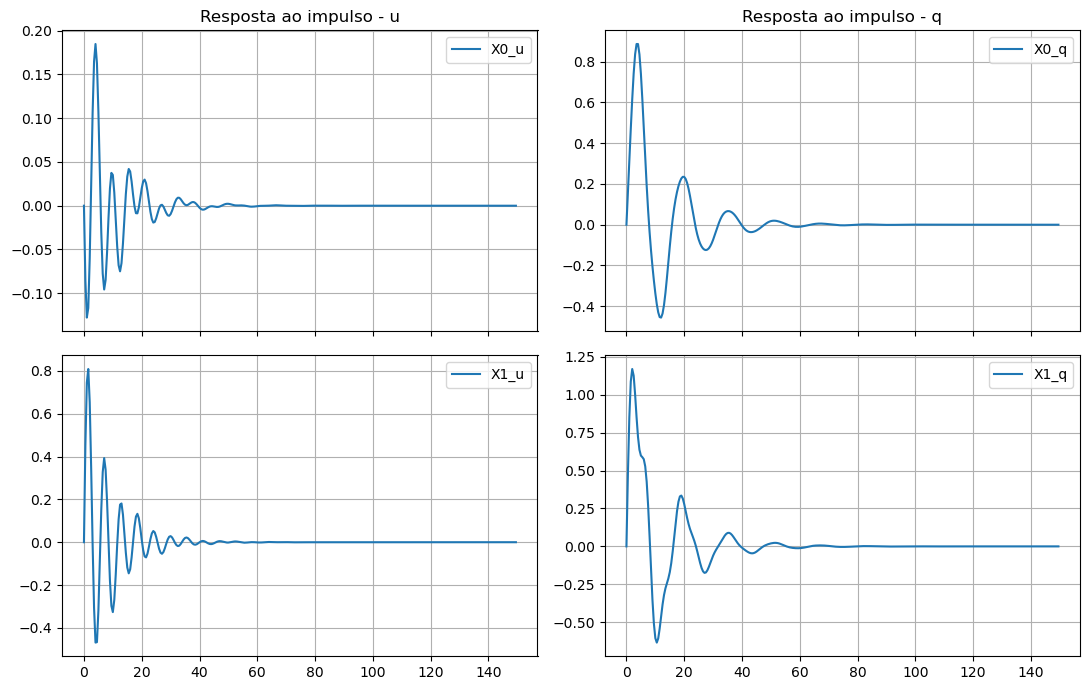

In [126]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_s_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Plot - resposta ao impulso
---

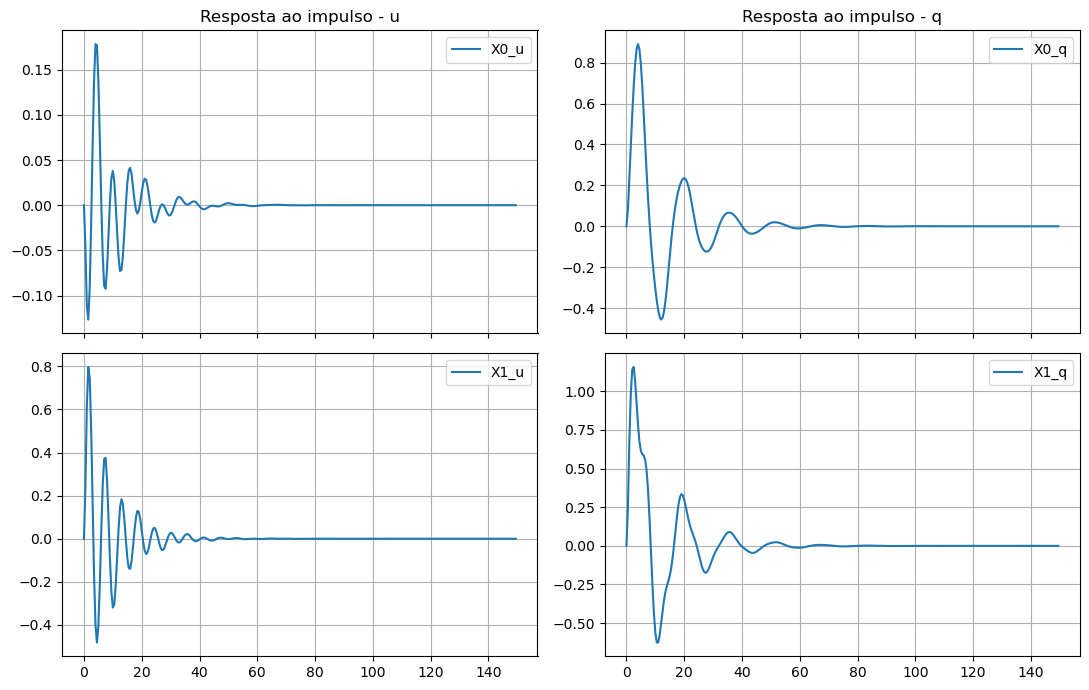

In [127]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_z_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Predição - usando CARIMA
---

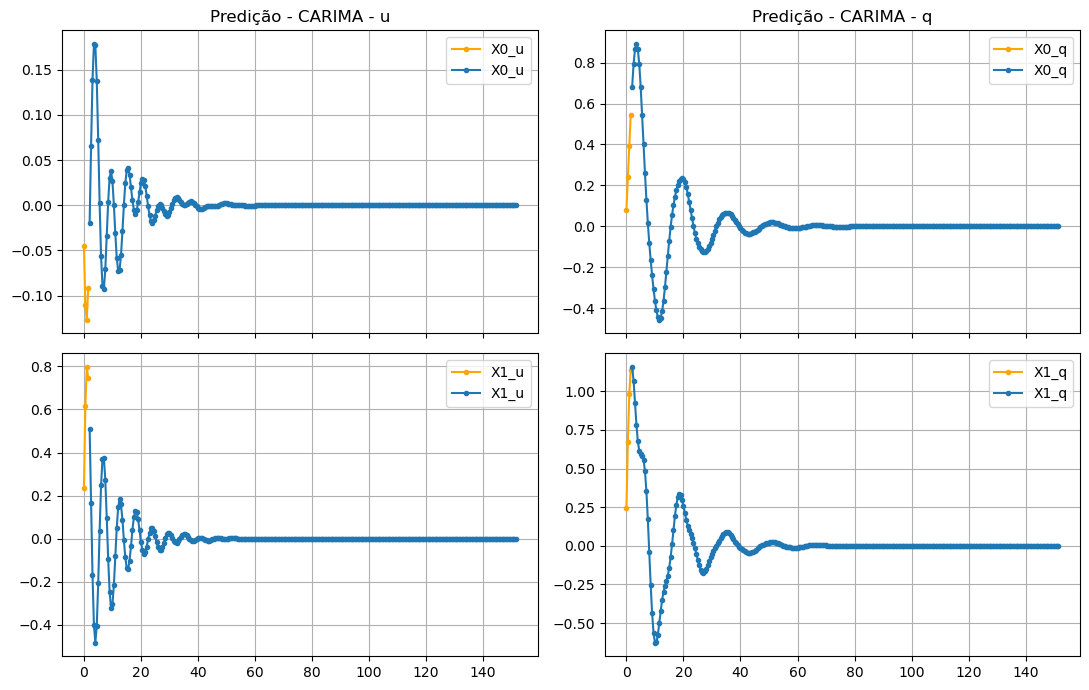

In [128]:
y_pred = [[] for _ in range(H.rows)]
y_pass = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        F = get_F(H_z_matriz[i][j], len(time))
        # pegar a condição inicial 
        y_in = y_matriz_out[i][j][0][1:F.shape[1]+1][::-1]

        # calcula a resposta livre
        y_out = F @ y_in

        # salva pra plotar
        y_plot0 = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', '.']
        y_plot1 = [y_in[::-1], "X{}_{}".format(i, cols_name[j]), 'orange', '.']
        y_pred[i].append(y_plot0)
        y_pass[i].append(y_plot1)

# plot 
plot(time, y_pred, "Predição - CARIMA", cols_name, time_aux=time, y_matriz_aux=y_pass)

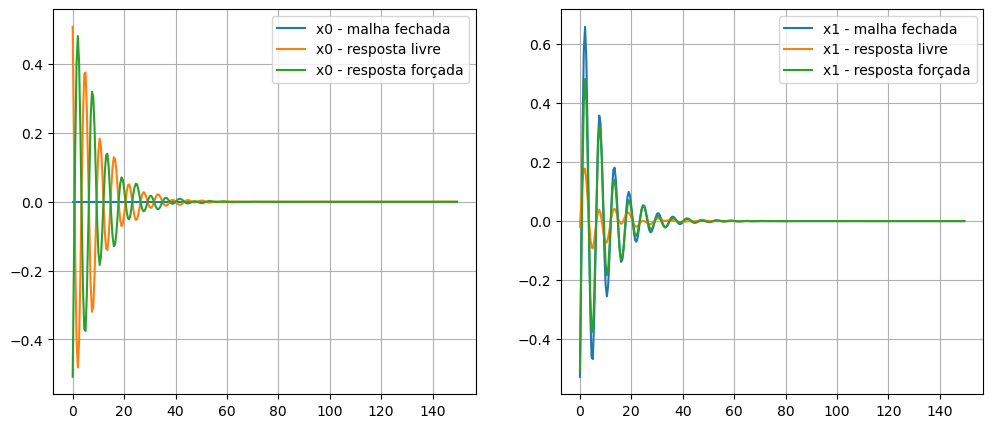

In [131]:
# ponderação nas ações de controle
alpha = 0.0
N_y = len(time)
N_u = len(time)

R = np.eye(N_u) * alpha
Q = np.eye(N_u) # monovariavel - delta é fixo = 1

F, G = generate_matrices(H_z_matriz[1][0], N_u, N_y)

# solution of quadratic problem
K = np.linalg.inv(G.T @ G + R) @ G.T

# solucao do sistema
x0_free = y_pred[1][0][0]
u_opt = -K @ x0_free

# calcula a resposta forçada
x0_forced = G @ u_opt

# resposta total 
x0 = x0_free + x0_forced

x1_free = y_pred[0][0][0]
x1_forced = G @ u_opt
x1 = x1_free + x1_forced

# plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(time, x0, label='x0 - malha fechada')
ax[0].plot(time, x0_free, label='x0 - resposta livre') 
ax[0].plot(time, x0_forced, label='x0 - resposta forçada')

ax[1].plot(time, x1, label='x1 - malha fechada')
ax[1].plot(time, x1_free, label='x1 - resposta livre')
ax[1].plot(time, x1_forced, label='x1 - resposta forçada')

for a in ax:
    a.grid()
    a.legend()
plt.show()
